# Part 1: Linear Classifier
-------

In [43]:
import torch
from torch import nn

# Hyperparameters
batch_size = 256
learning_rate=.1
nepochs = 5
hidden=[6144, 6144]
LossFunction = nn.CrossEntropyLoss()
bias = False

# Input size
ninputs=3*32*32

# Output size
nout=10

# Use GPU if avaiable
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 2070 SUPER


In [41]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import random_split

cifar10_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

# Split the data into a training data set, validation set, and a test set - first get sizes
# CIFAR10 has 50000 images, so I'll split the data up into 37500 for training, 7500 for validation
# and 5000 for testing
train_data_size = 37500
val_data_size = 7500
test_data_size = 5000

# Randomsplit with will split the data from cifar10 dataset into train, val, and test with their respective sizes  
train_dataset, val_dataset, test_dataset = random_split(cifar10_dataset, [train_data_size, val_data_size, test_data_size])

# We can now load the data with DataLoader from these datasets 
train_data = DataLoader(train_dataset,
                        batch_size=batch_size,
                        )

val_data = DataLoader(val_dataset,
                      batch_size=batch_size,
                      )

test_data = DataLoader(test_dataset,
                       batch_size=batch_size,
                       )


Files already downloaded and verified


In [44]:
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful
from torchvision import datasets
import matplotlib.pyplot as plt

class LinearNet(nn.Module):
    def __init__(self,
                 ninputs=3*32*32,
                 hidden=[512],
                 nout=10,
                ):
        super().__init__()
        net = []
        # Input layer
        net.append(nn.Linear(ninputs, hidden[0], bias=bias))
        net.append(nn.ReLU())
        
        # Hidden layers
        if len(hidden) > 1:
          for i in range(len(hidden) - 1):
            net.append(nn.Linear(hidden[i], hidden[i+1], bias=bias))
            net.append(nn.ReLU())

        # Output Layer
        net.append(nn.Linear(hidden[-1], nout, bias=bias))
        net.append(nn.ReLU())
        self.net = nn.Sequential(*net)
        
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1) # Flatten image
        x = self.net(x)
        return x

LinearNet(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=6144, bias=False)
    (1): ReLU()
    (2): Linear(in_features=6144, out_features=6144, bias=False)
    (3): ReLU()
    (4): Linear(in_features=6144, out_features=10, bias=False)
    (5): ReLU()
  )
)


Epoch:   0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch 0: loss: 2.0726964473724365
Epoch 1: loss: 2.0900208950042725
Epoch 2: loss: 1.8901395797729492
Epoch 3: loss: 1.665015697479248
Epoch 4: loss: 1.5694950819015503


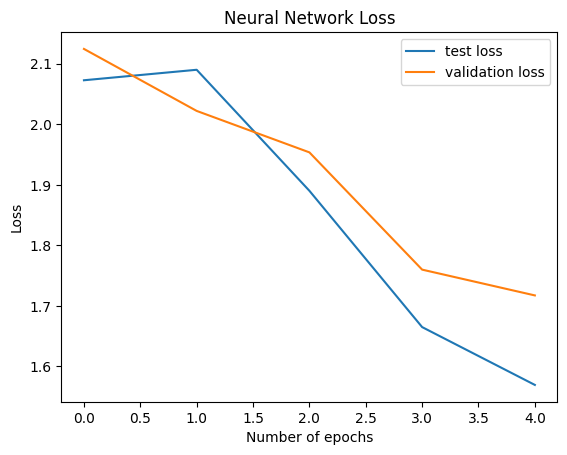

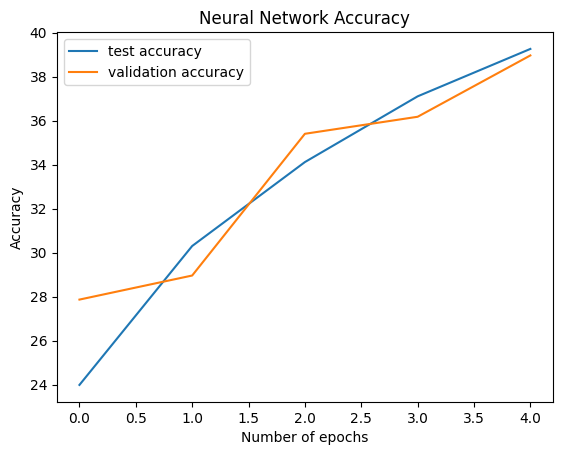

In [45]:
model = LinearNet(ninputs=ninputs,
                  hidden=hidden,
                  nout=nout).to(device)
print(model)
# We need an optimizer that tells us what form of gradient descent to do
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in notebook.trange(nepochs,
                  desc="Epoch",
                  unit="epoch",
                  disable=False):
    correct = 0
    total = 0
    model.train()
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True)
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        loss = LossFunction(out, label)
        loss.backward()
        optimizer.step()
    
        # Used chatGPT to help write this accuracy code     
        _, predicted = torch.max(out.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
    accuracy = 100 * correct / total
    acc_history.append(accuracy)
    loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")
    torch.save(model.state_dict(), "model_epoch_{}.pt".format(epoch))
    
    
    # Validation
    model.eval() # No longer training - comparing loss and accuracy in our validation set
    correct = 0
    total = 0
    with torch.no_grad(): # Don't want to update the gradients
        for (data, label) in val_data:
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            loss = LossFunction(out, label)

            # Used chatGPT to help write this accuracy code     
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
        accuracy = 100 * correct / total
        val_acc_history.append(accuracy)
        val_loss_history.append(loss.item())            
          

plt.plot(loss_history, label='test loss')
plt.plot(val_loss_history, label='validation loss')
plt.title("Neural Network Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(acc_history, label='test accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.title("Neural Network Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Parameters:

learning_rate=.01

nepochs = 20

hidden=[6144, 6144, 6144]

batch_size = 128

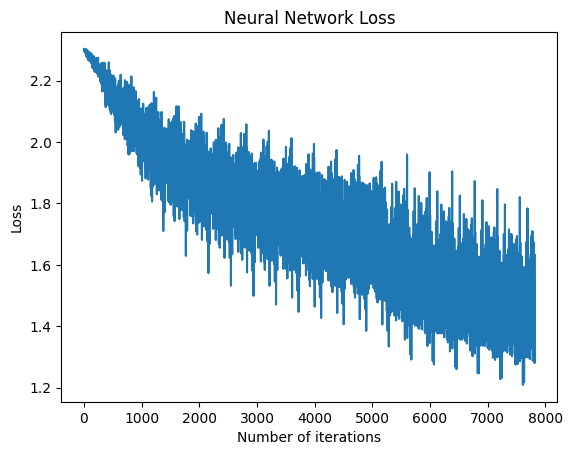

Total accuracy = 49.42%

Parameters:

learning_rate=.1

nepochs = 50

hidden=[6144, 6144]

nout=10

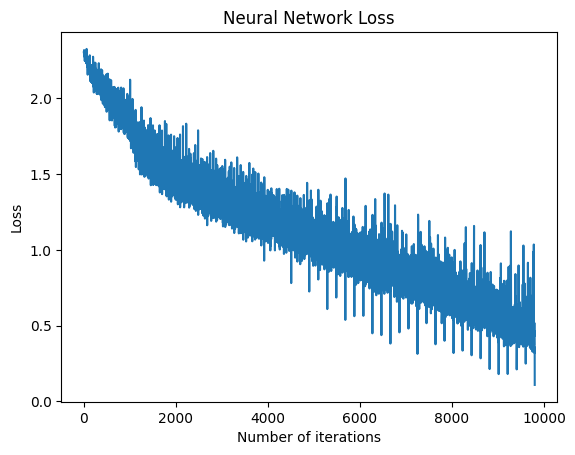

Training Time: 7m 10.0s

Total accuracy = 81.69%



In [17]:
test_data = DataLoader(cifar10_dataset,
                       batch_size=batch_size,
                        )

# Let's set up some parameters
learning_rate=.1
nepochs = 5
ninputs=3*32*32
hidden=[6144, 6144]
nout=10

model = LinearNet(ninputs=ninputs,
                  hidden=hidden,
                  nout=nout).to(device)

state_dict = torch.load("model_epoch_49.pt")
model.load_state_dict(state_dict)
model.eval()

accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / len(cifar10_dataset)*100:.2f}%")

Total accuracy = 81.69%


# Part 1 Results:
-------
## Test 1
#### Parameters:
- Batch size of 256
- Learning rate of .1
- Epochs = 50
- Hidden layers: 2
- Hidden layer sizes - both 6144
- Loss Function: Cross Entropy
- Trained linear classifiers with bias term

### Findings
...

## Test 2
#### Parameters: